# NYC Taxi Trip Duration - EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

from scipy import stats
from shapely.geometry import Point, Polygon, LineString

%matplotlib inline
pd.set_option("display.float_format", "{:.2f}".format)

In [2]:
# Define constants
lib_loc = "/Users/nomic/Desktop/Nomi/develop/kiggle"
nyc_coord = [40.730610, -73.935242] #lat, long

In [3]:
# Define functions

# Interactive trips map plotting

def map_trips(df):

    trips_map = folium.Map(location = nyc_coord,  tiles="OpenStreetMap", zoom_start = 11)


    for idx, row in df.iterrows():
        folium.CircleMarker(location = 
                            [row['pickup_latitude'], row['pickup_longitude']],
                            radius = 2,
                            color = 'blue',
                            popup = "ID: " + str(row['id'])
                            + "<br>"
                            + "Date-time: " + str(row['pickup_datetime'])
                            + "<br>"
                            + "Duration (sec): " + str(row['trip_duration'])
                            + "<br>"
                            + "Distance (meters): " + str(row['distance'])
                            + "<br>"
                            + "Speed (km/hr): " + str(row['speed'])
                           ).add_to(trips_map)
    
    
        folium.CircleMarker(location = [row['dropoff_latitude'], row['dropoff_longitude']],
                            radius = 2, 
                            color = 'red',
                            popup = "ID: " + str(row['id'])
                            + "<br>"
                            + "Date-time: " + str(row['dropoff_datetime'])
                            + "<br>"
                            + "Duration (sec): " + str(row['trip_duration'])
                            + "<br>"
                            + "Distance (meters): " + str(row['distance'])
                            + "<br>"
                            + "Speed (km/hr): " + str(row['speed'])
                           ).add_to(trips_map)
        #add lines
        folium.PolyLine(locations = [[row['pickup_latitude'], row['pickup_longitude']],[row['dropoff_latitude'], row['dropoff_longitude']]], 
                        color="green", weight=1, opacity=1).add_to(trips_map)
    
    return trips_map


In [4]:
# Load the Data
train_data = pd.read_csv(lib_loc + '/data/train.csv')
test_data = pd.read_csv(lib_loc +'/data/test.csv')
train_df = train_data.copy() # Create a copy df that we will edit instead of the raw data

In [5]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435


In [6]:
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.99,40.73,-73.99,40.76,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.96,40.68,-73.96,40.66,N
2,id1217141,1,2016-06-30 23:59:47,1,-74.00,40.74,-73.99,40.73,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.96,40.77,-73.99,40.73,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.97,40.76,-73.96,40.76,N


In [7]:
# Summary Statistics
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


In [8]:
# Missing Values
train_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
# Unique Values for each variable
train_df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

In [10]:
# Data Types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [11]:
# Convert columnns to correct data types
train_df['vendor_id'] = train_df['vendor_id'].astype('category')
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].astype('category')
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['dropoff_datetime'] = pd.to_datetime(train_df['dropoff_datetime'])

Text(0.5, 1.0, 'Histogram of Log(Column)')

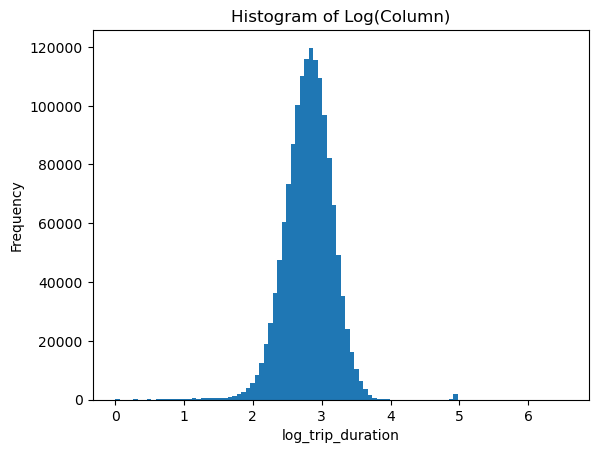

In [12]:
# Examine distribution of the target variable (trip duration)
# Plot the log of the duration since the distribution is skewed
plt.hist(np.log10(train_df['trip_duration']), bins = 100);
plt.xlabel('log_trip_duration')
plt.ylabel('Frequency')
plt.title('Histogram of Log(Column)')

In [13]:
# Check how many trips there are with unreasonably long/short durations
print(train_df.loc[train_df['trip_duration'] > 5*60*60, 'id'].count(), 'trips longer than 5 hours')
print(train_df.loc[train_df['trip_duration'] > 24*60*60, 'id'].count(), 'trips longer than 24 hours')
print(train_df.loc[train_df['trip_duration'] < 60, 'id'].count(), 'trips shorter than a minute')
# Most likely these values should be removed, but we'll keep them for now and look at the distances of these trips before deciding what to do with them

2072 trips longer than 5 hours
4 trips longer than 24 hours
8595 trips shorter than a minute


In [14]:
# look at number and duration of trips by vendor
train_df['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

<Axes: xlabel='log_duration', ylabel='Count'>

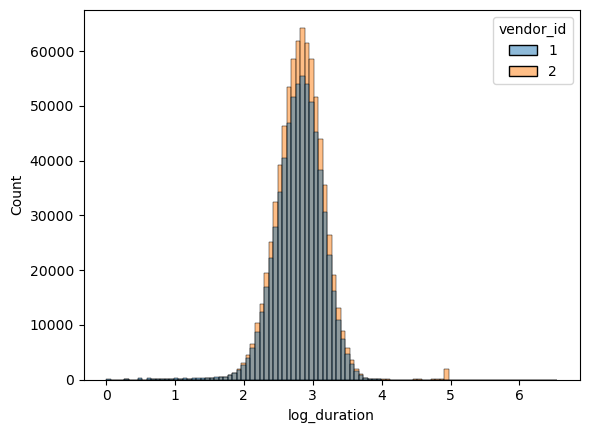

In [15]:
train_df['log_duration'] = np.log10(train_df['trip_duration'])
sns.histplot(data = train_df, x = 'log_duration', hue = 'vendor_id', bins = 100)

*looks like the long trips are made by vendor 2

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: count, dtype: int64


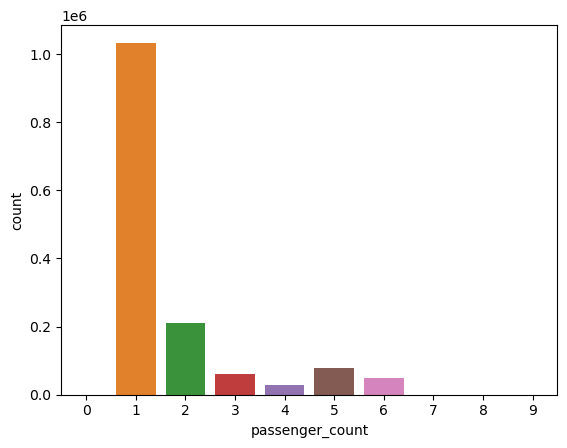

In [16]:
# Number and duration of trips by passenger number
sns.countplot(x=train_df['passenger_count'])
print(train_df['passenger_count'].value_counts().sort_index())

<Axes: xlabel='passenger_count', ylabel='log_duration'>

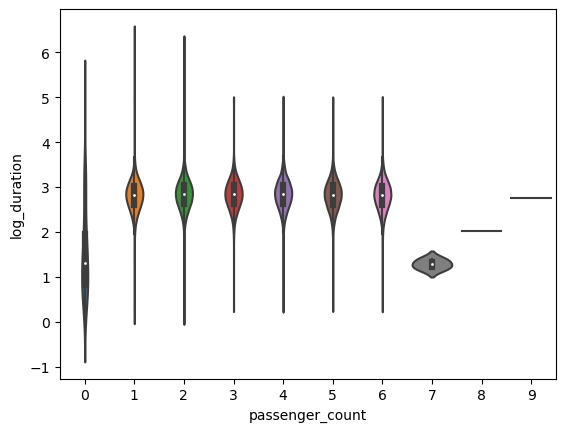

In [17]:
sns.violinplot(x='passenger_count',y = 'log_duration', data = train_df)

*There are barely any trips with passenger_count > 6, possibly these trips should be grouped
*trips with 0 passengers are short - maybe these should be deleted

## Effects of time on trip quantity & duration

In [18]:
# Create time & distance columns
train_df['day'] = train_df['pickup_datetime'].dt.day_name()
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df['pickup_month'] = train_df['pickup_datetime'].dt.month
train_df['pickup_date'] = train_df['pickup_datetime'].dt.date
train_df['is_workday'] = train_df['pickup_datetime'].dt.dayofweek
train_df['is_workday'] = train_df['is_workday'] < 5

In [19]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_duration,day,pickup_hour,pickup_month,pickup_date,is_workday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,2.66,Monday,17,3,2016-03-14,True
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,2.82,Sunday,0,6,2016-06-12,False
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124,3.33,Tuesday,11,1,2016-01-19,True
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429,2.63,Wednesday,19,4,2016-04-06,True
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435,2.64,Saturday,13,3,2016-03-26,False


Text(0, 0.5, 'number of trips')

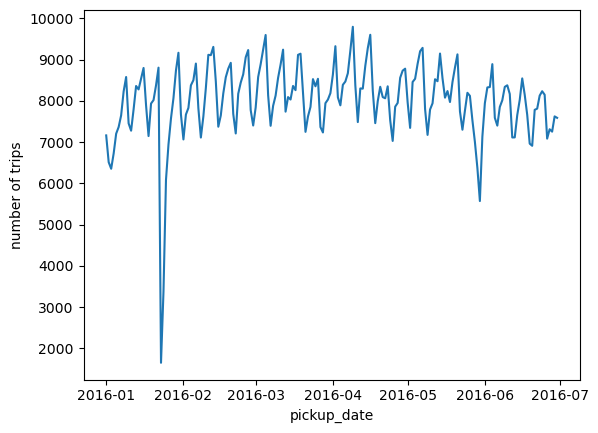

In [20]:
# plot the count of trips by date
count_trips_by_date = train_df.groupby('pickup_date')['id'].count()
sns.lineplot(data=count_trips_by_date)
plt.ylabel('number of trips')

Text(0, 0.5, 'number of trips')

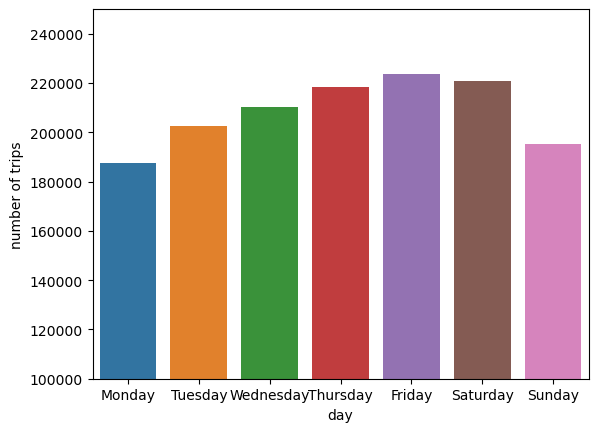

In [21]:
# Daily effects
sns.countplot(x=train_df['day'], order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylim(100000,250000)
plt.ylabel('number of trips')

Text(0, 0.5, 'median trip duration (sec)')

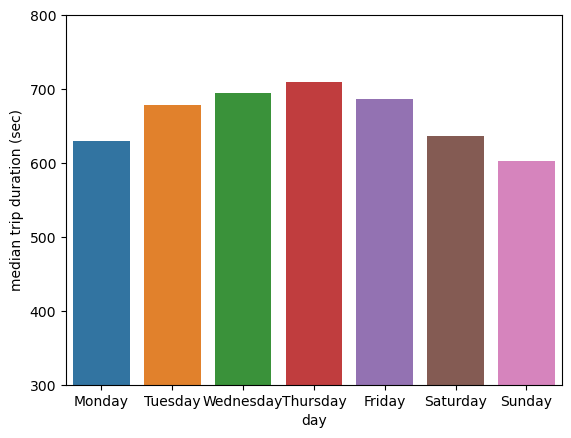

In [22]:
df = train_df.groupby('day')['trip_duration'].median().reset_index()
sns.barplot(x='day',y = 'trip_duration', data = df, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylim(300,800)
plt.ylabel('median trip duration (sec)')

Text(0, 0.5, 'number of trips')

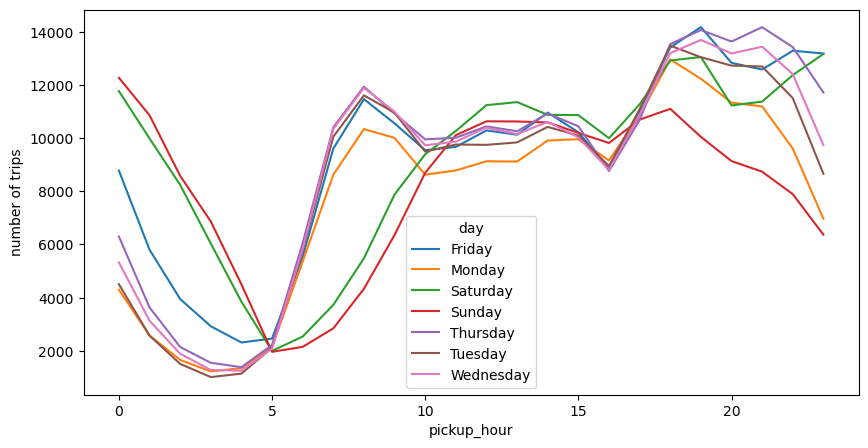

In [23]:
# effects by day and hour
fig, ax = plt.subplots(figsize=(10,5))
df = train_df.groupby(['day', 'pickup_hour'])['id'].count().reset_index()
sns.lineplot(ax = ax, data=df, x = 'pickup_hour', y = 'id', hue = 'day')
plt.ylabel('number of trips')

## Geographical exploration

In [24]:
# Turn long and lat into points and convert to NYC coordinate system
train_df['pickup_points']  = gpd.points_from_xy(train_df['pickup_longitude'], train_df['pickup_latitude'], crs = "EPSG:4326").to_crs('EPSG:2263')
train_df['dropoff_points'] =  gpd.points_from_xy(train_df['dropoff_longitude'], train_df['dropoff_latitude'], crs = "EPSG:4326").to_crs('EPSG:2263')
train_df['line'] = [LineString(pair) for pair in zip(train_df['pickup_points'], train_df['dropoff_points'])] 

# Convert to geo data frame
train_df = gpd.GeoDataFrame(train_df, geometry=train_df['pickup_points'])
train_df['distance'] = train_df['pickup_points'].distance(train_df['dropoff_points']) # distances in feet
train_df['distance'] = train_df['distance'] / 3.281 # convert distance to meters
train_df['speed'] = (train_df['distance'] / 1000) / (train_df['trip_duration'] / 3600)

rides removed due to large distance:  222


<Axes: xlabel='distance', ylabel='Count'>

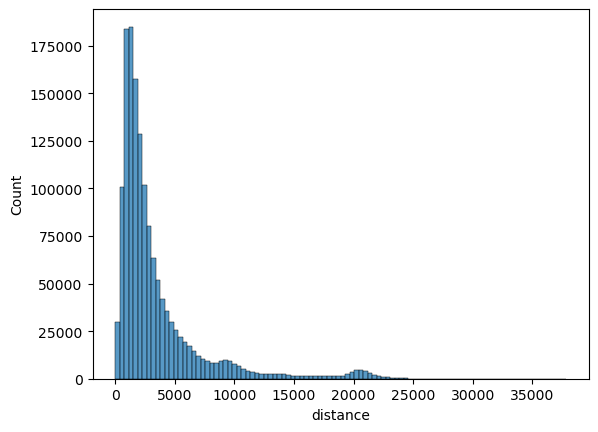

In [25]:
# Examine the distribution of trip distances
# limit data to 4 std due to some extreme outliers
df = train_df[(stats.zscore(train_df['distance'])) < 8]
print("rides removed due to large distance: ", train_df.shape[0] - df.shape[0])
sns.histplot(data = df, x = 'distance', bins = 100)

rides removed due to location:  292


<Axes: xlabel='pickup_longitude', ylabel='pickup_latitude'>

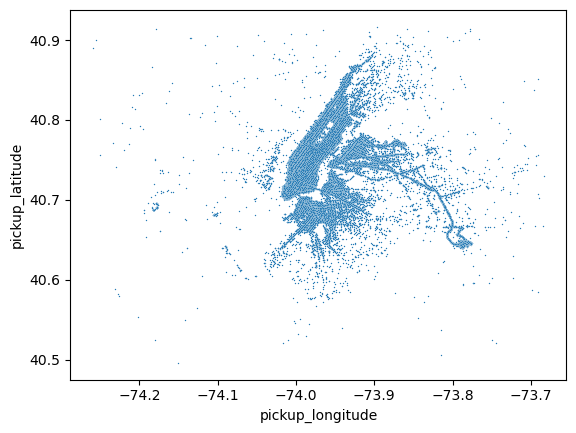

In [26]:
# Plot pickup locations
# limit to NYC boundaries
top_bnd = 40.92,
bottom_bnd = 40.49,
left_bnd = -74.27,
right_bnd = -73.68,
df = train_df.loc[(train_df['pickup_longitude'] < right_bnd) & (train_df['pickup_longitude'] > left_bnd) 
                 & (train_df['pickup_latitude'] < top_bnd) & (train_df['pickup_latitude'] > bottom_bnd)]

print("rides removed due to location: ", train_df.shape[0] - df.shape[0])

# plot pickup coordinates
sns.scatterplot(data = df, x = 'pickup_longitude', y = 'pickup_latitude', s = 1)

rides removed due to location:  1200


<Axes: xlabel='dropoff_longitude', ylabel='dropoff_latitude'>

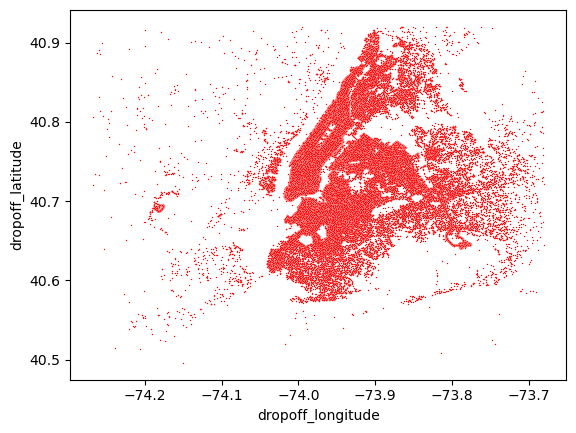

In [27]:
# Plot dropoff locations
# limit to NYC boundaries
top_bnd = 40.92,
bottom_bnd = 40.49,
left_bnd = -74.27,
right_bnd = -73.68,
df = train_df.loc[(train_df['dropoff_longitude'] < right_bnd) & (train_df['dropoff_longitude'] > left_bnd) 
                 & (train_df['dropoff_latitude'] < top_bnd) & (train_df['dropoff_latitude'] > bottom_bnd)]

print("rides removed due to location: ", train_df.shape[0] - df.shape[0])
# plot pickup coordinates
sns.scatterplot(data = df, x = 'dropoff_longitude', y = 'dropoff_latitude', s = 1, color = 'red')

rides removed due to unfeasible speed:  98


<Axes: xlabel='speed', ylabel='Count'>

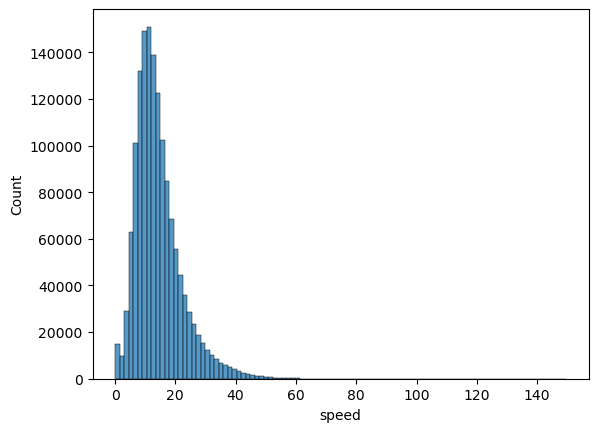

In [28]:
# Examine the distribution of trip speed
# limit data to a feasible speed
df = train_df[train_df['speed'] < 150]
print("rides removed due to unfeasible speed: ", train_df.shape[0] - df.shape[0])
sns.histplot(data = df, x = 'speed', bins = 100)

In [29]:
# Plot random sample of rides on NYC map
n = 100
sampled_rides = train_df.sample(n=n).reset_index()
map = map_trips(sampled_rides)
map


In [30]:
# plot the 50 longest duration trips
n = 50
longest_rides = train_df.nlargest(n, 'trip_duration')
longest_map = map_trips(longest_rides)
longest_map

In [31]:
# plot the 50 shortest duration trips
n = 50
shortest_rides = train_df.nsmallest(n, 'trip_duration')
shortest_map = map_trips(shortest_rides)
shortest_map

In [32]:
# Plot longest distance trips
n = 50
furthest_rides = train_df.nlargest(n, 'distance')
furthest_map = map_trips(furthest_rides)
furthest_map

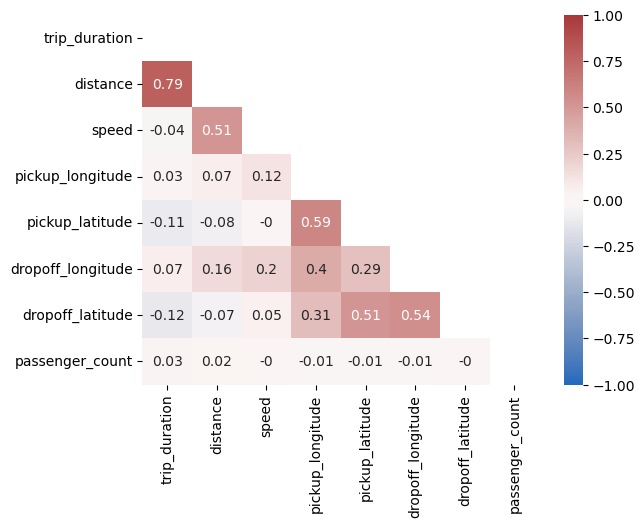

In [33]:
df = train_df[['trip_duration', 'distance', 'speed', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']]
matrix = df.corr('spearman').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

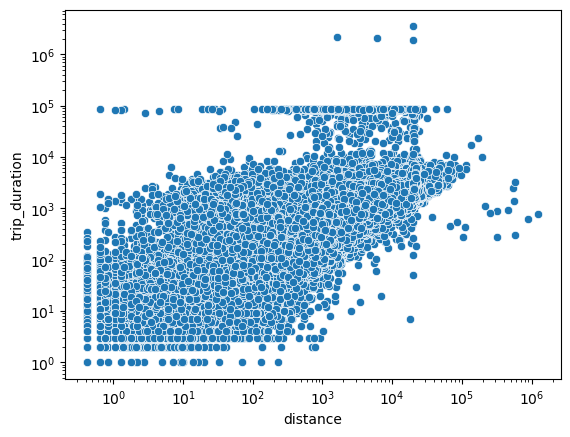

In [34]:
# plot relationship between distance and trip time
sns.scatterplot(data = train_df, x = 'distance', y = 'trip_duration')
plt.xscale('log')
plt.yscale('log')

<Axes: xlabel='passenger_count', ylabel='trip_duration'>

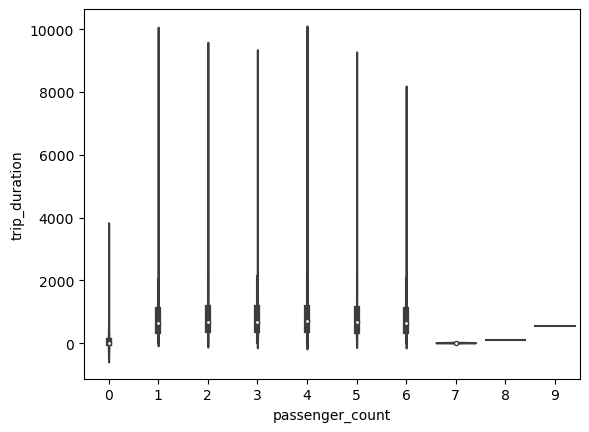

In [35]:
sns.violinplot(data = train_df[train_df['trip_duration'] < 10000], x = 'passenger_count', y = 'trip_duration')

vendor_iid (cat)
pickup_hr
pickup_day



In [36]:
pd.get_dummies

<function pandas.core.reshape.encoding.get_dummies(data, prefix=None, prefix_sep: 'str | Iterable[str] | dict[str, str]' = '_', dummy_na: 'bool' = False, columns=None, sparse: 'bool' = False, drop_first: 'bool' = False, dtype: 'NpDtype | None' = None) -> 'DataFrame'>